In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Load the dataset
df = pd.read_csv('./data/Booking_Jobs_All_220218.csv')

In [3]:
# Display the first few rows of the dataframe
print(df.head())

                                    Job Title  \
0                   Junior Endpoints Engineer   
1                             UX Writer - B2B   
2                    Treasury Risk Specialist   
3  Product Manager - Insurance - Policy Admin   
4              Account Executive - Manchester   

                                     Job Description  \
0  Booking.com\r\nIt wasn’t so long ago that book...   
1  At Booking.com, data drives our decisions. Tec...   
2  Booking.com’s global treasury team is looking ...   
3  About the company\r\nIt wasn’t so long ago tha...   
4  Account Executive - Bristol\r\nThis is a full ...   

                     Location                            Team  
0  Manchester, United Kingdom                     Engineering  
1      Amsterdam, Netherlands        Design & User Experience  
2      Amsterdam, Netherlands                         Finance  
3  Manchester, United Kingdom                         Product  
4  Manchester, United Kingdom  Business Developm

In [4]:
# Get the job descriptions
job_descriptions = df['Job Description'].dropna()

In [5]:
job_descriptions

0      Booking.com\r\nIt wasn’t so long ago that book...
1      At Booking.com, data drives our decisions. Tec...
2      Booking.com’s global treasury team is looking ...
3      About the company\r\nIt wasn’t so long ago tha...
4      Account Executive - Bristol\r\nThis is a full ...
                             ...                        
648    It wasn’t so long ago that booking a trip so s...
649    Senior Front End Developer\r\nWho are we?\r\nA...
650    At Booking.com, we make it easier for everyone...
651    Senior Java Developer\r\n  Who are we? \r\nAt ...
652    At Booking.com, data drives our decisions. Tec...
Name: Job Description, Length: 653, dtype: object

In [6]:
# Initialise the PorterStemmer
stemmer = PorterStemmer()

# Step 1: Perform Text Pre-processing

### Pre-processing text data is essential to convert raw text into a format that can be used by machine learning algorithms. This usually includes steps like tokenization, removing stop words, stemming/lemmatization, and converting text to a numeric format.

In [7]:
# Define a function for text pre-processing
def preprocess_text(text):
    # Tokenise the text
    tokens = nltk.word_tokenize(text)
    # Convert to lower-case
    tokens = [word.lower() for word in tokens]
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Perform stemming
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

In [8]:
# Apply the preprocessing function to the data
job_descriptions = job_descriptions.apply(preprocess_text)

In [9]:
job_descriptions

0      booking.com ’ long ago book trip see eiffel to...
1      booking.com , data drive decis . technolog cor...
2      booking.com ’ global treasuri team look treasu...
3      compani ’ long ago book trip see eiffel tower ...
4      account execut - bristol full time posit base ...
                             ...                        
648    ’ long ago book trip see eiffel tower , stroll...
649    senior front end develop ? booking.com , make ...
650    booking.com , make easier everyon experi world...
651    senior java develop ? booking.com , make easie...
652    booking.com , data drive decis . technolog cor...
Name: Job Description, Length: 653, dtype: object

# Step 2: Identify Number of Natural Clusters

### We can use methods like the Elbow method or Silhouette score to determine the optimal number of clusters.



In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [11]:
# Convert text data to numerical data using Tfidf
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(job_descriptions).toarray()

In [12]:
# Use the elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

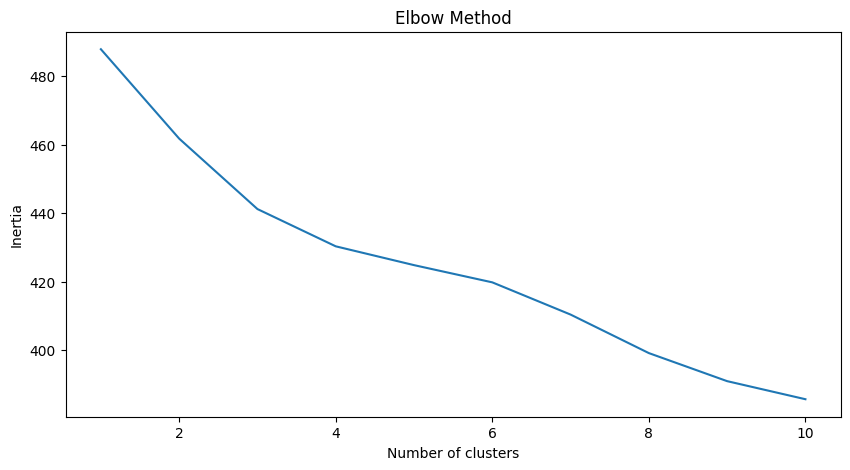

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Step 3: Train the Clustering Model


### Based on the elbow method, choose the optimal number of clusters and train a KMeans model.



In [14]:
# Assume the optimal number of clusters is 4 (You can get this from the Elbow plot)
optimal_clusters = 4

In [15]:
# Train the KMeans model
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [16]:
# Get the cluster labels
labels = kmeans.labels_
df['Cluster'] = labels

# Step 4: Identify Keywords from Each Cluster


### We can identify the top keywords using the centroids of each cluster.



In [17]:
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

In [18]:
# Get the feature names
feature_names = tfidf.get_feature_names_out()

In [19]:
# Find the top keywords for each cluster
top_keywords = {}
for i in range(optimal_clusters):
    words = [feature_names[index] for index in cluster_centers[i].argsort()[-10:]]
    top_keywords[i] = words

print(top_keywords)

{0: ['booking', 'com', 'engin', 'develop', 'data', 'work', 'experi', 'team', 'design', 'product'], 1: ['booking', 'com', 'project', 'support', 'abil', 'work', 'experi', 'busi', 'team', 'manag'], 2: ['world', 'manag', 'busi', 'account', 'portfolio', 'hotel', 'com', 'booking', 'bv', 'partner'], 3: ['opportun', 'team', 'technic', 'booking', 'engin', 'com', 'develop', 'work', 'experi', 'product']}


# Step 5: Deploy the Model


### Deploying as a REST API with Flask:



In [25]:
from flask import Flask, request, jsonify

In [26]:
app = Flask(__name__)

In [27]:
@app.route('/predict', methods=['POST'])
def predict():
    job_description = request.json.get('job_description', '')
    if not job_description:
        return jsonify({'error': 'Job description not provided'}), 400
    
    preprocessed_text = preprocess_text(job_description)
    X_new = tfidf.transform([preprocessed_text]).toarray()
    cluster = kmeans.predict(X_new)[0]
    
    return jsonify({'cluster': int(cluster), 'keywords': top_keywords[cluster]})

